In [1]:
## SIREN (Sitzman et al. 2020) x deepOnet 
#https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_operators/simple_deepOnet_in_JAX.ipynb


In [13]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
from equinox import static_field
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from jaxtyping import Array, Float
from typing import Union, Sequence, Callable
import optax


In [14]:
# The dataset is curtesy of the DeepXDE library (Lu et al.), was used in a
# tutorial similar in scope to this notebook
# https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html
# Download from a github repository of ETH Zurich's course on "Deep Learning in
# Scienfitic Computing"
# !wget https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_train.npz
# !wget https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_test.npz


In [15]:
dataset_train = jnp.load("antiderivative_aligned_train.npz", allow_pickle=True)
branch_inputs_train = dataset_train["X"][0]
trunk_inputs_train = dataset_train["X"][1]
outputs_train = dataset_train["y"]

print(f"{branch_inputs_train.shape=} {trunk_inputs_train.shape=} {outputs_train.shape=}")

dataset_test = jnp.load("antiderivative_aligned_test.npz", allow_pickle=True)
branch_inputs_test = dataset_test["X"][0]
trunk_inputs_test = dataset_test["X"][1]
outputs_test = dataset_test["y"]

print(f"{branch_inputs_test.shape=} {trunk_inputs_test.shape=} {outputs_test.shape=}")



branch_inputs_train.shape=(150, 100) trunk_inputs_train.shape=(100, 1) outputs_train.shape=(150, 100)
branch_inputs_test.shape=(1000, 100) trunk_inputs_test.shape=(100, 1) outputs_test.shape=(1000, 100)


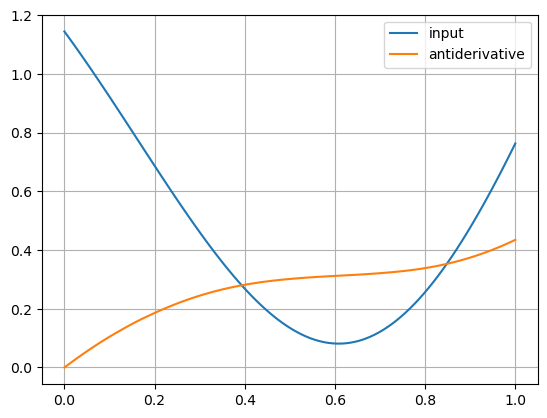

In [16]:
plt.plot(
    trunk_inputs_train[:, 0],
    branch_inputs_train[2, :],
    label="input",
)
plt.plot(
    trunk_inputs_train[:, 0],
    outputs_train[2, :],
    label="antiderivative",
)
plt.legend()
plt.grid()

In [21]:
class SirenLayer(eqx.Module):
    weight: Float[Array, "out_size in_size"]
    bias: Float[Array, "out_size"]

    def __init__(self, in_size: int, out_size: int, w0: float, is_first_layer: bool, *, key: Array):
        w_key, b_key = jr.split(key)
        lim = 1/in_size if is_first_layer == 0 else jnp.sqrt(6. /in_size) / w0
        self.weight =  jr.uniform(
            key=w_key,
            shape=(out_size, in_size),
            minval=-lim,
            maxval=lim
        ) 

        bias_factor = jnp.pi / jnp.sqrt(
            jnp.sum(jnp.square(self.weight), axis=1))  
        
        self.bias = jr.uniform(
            key=b_key,
            shape=(out_size,),
            minval=-1,
            maxval=1
        ) * bias_factor

    def __call__(self, x: Float[Array, "in_size"]) -> Float[Array, "out_size"]:
        return self.weight @ x + self.bias


        
class SIREN(eqx.Module):
    layers: Sequence[SirenLayer]
    w0:     Float[Array, ""]  
    
    def __init__(self, in_size, out_size, width_size, depth, w0, learnable_w0=False, *, key):
        widths = [in_size] + [width_size]* (depth - 1) + [out_size]
        keys = jr.split(key, len(widths))
        
        self.layers = tuple(
            SirenLayer(widths[i], widths[i+1], w0, i, key= keys[i])
            for i in range(len(widths)-1)
        )
        self.w0 = w0 if learnable_w0 else jax.lax.stop_gradient(w0)
        
    def __call__(self, x: Float[Array, "in_size"]) -> Float[Array, "out_size"]:
        h = x
        for layer in self.layers[:-1]:
            h = jnp.sin( self.w0 * layer(h))
        return self.layers[-1](h).squeeze()



class DeepONet1d(eqx.Module):
    branch_net: eqx.nn.MLP
    trunk_net: eqx.nn.MLP
    bias: jax.Array
    w0:     Float[Array, ""]  

    def __init__(
        self,
        in_size_branch,
        width_size,
        depth,
        interact_size,
        w0,
        learnable_w0 = False,
        *,
        key,
    ):
        """
        For simplicity, branch and trunk MLP are configured similarly
        """
        b_key, t_key = jr.split(key)
        self.branch_net = SIREN(
            in_size=in_size_branch,
            out_size=interact_size,
            width_size=width_size,
            depth=depth,
            w0=w0,
            learnable_w0 = learnable_w0,
            key=b_key,
        )
        self.trunk_net =SIREN(
            in_size=1,
            out_size=interact_size,
            width_size=width_size,
            depth=depth,
            w0=w0,
            learnable_w0 = learnable_w0,
            key=t_key,
        )
        self.bias = jnp.zeros((1,))
        self.w0 = w0 if learnable_w0 else jax.lax.stop_gradient(w0)

    def __call__(self, x_branch, x_trunk):
        """
        x_branch.shape = (in_size_branch,)
        x_trunk.shape = (1,)

        return shape: "scalar"
        """
        branch_out = self.branch_net(x_branch)
        trunk_out = jnp.sin(self.w0* self.trunk_net(x_trunk))
        inner_product = jnp.sum(branch_out * trunk_out, keepdims=True)

        return (inner_product + self.bias).squeeze()
        
        
class ConvBranch(eqx.Module):
    """
    1D convolutional branch network for DeepONet.
    Takes input of shape (in_channels, length) and outputs interact_size features.
    """
    convs: Sequence[eqx.nn.Conv1d]
    flatten: Callable[[Array], Array]
    linear: eqx.nn.Linear

    def __init__(
        self,
        in_channels: int,
        length: int,
        interact_size: int,
        conv_channels: Sequence[int],
        kernel_size: int,
        key: jr.PRNGKey,
    ):
        # Build convolutional layers
        keys = jr.split(key, len(conv_channels) + 1)
        layers = []
        current_channels = in_channels
        # Create conv1d layers with ReLU after each
        for i, out_ch in enumerate(conv_channels):
            layers.append(
                eqx.nn.Conv1d(
                    in_channels=current_channels,
                    out_channels=out_ch,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=kernel_size // 2,
                    key=keys[i]
                )
            )
            current_channels = out_ch
        self.convs = tuple(layers)
        # Flatten to vector
        self.flatten = lambda x: x.reshape(-1)
        # Final linear mapping to interact_size
        self.linear = eqx.nn.Linear(current_channels * length, interact_size, key=keys[-1])

    def __call__(self, x: Float[Array, "in_channels length"]) -> Float[Array, "interact_size"]:
        h = x
        for conv in self.convs:
            h = conv(h)
            h = jax.nn.relu(h)
        h = self.flatten(h)
        return self.linear(h)

class ConvolutionalDeepONet1d(eqx.Module):
    branch_net: ConvBranch
    trunk_net: eqx.nn.MLP
    bias: jax.Array

    def __init__(
        self,
        in_size_branch: int,
        length: int,
        in_size_trunk: int,
        interact_size: int,
        conv_channels: Sequence[int],
        kernel_size: int,
        trunk_hidden_sizes: Sequence[int],
        key: jr.PRNGKey,
    ):
        b_key, t_key = jr.split(key)
        # Branch takes a single-channel sequence of length `length`
        self.branch_net = ConvBranch(
            in_channels=1,
            length=length,
            interact_size=interact_size,
            conv_channels=conv_channels,
            kernel_size=kernel_size,
            key=b_key,
        )
        # Trunk MLP maps scalar to interact_size
        self.trunk_net = eqx.nn.MLP(
            in_size=in_size_trunk,
            out_size=interact_size,
            width_size=trunk_hidden_sizes[0],
            depth=len(trunk_hidden_sizes),
            key=t_key,
        )
        self.bias = jnp.zeros(())

    def __call__(
        self,
        x_branch: Float[Array, "length"],
        x_trunk: Float[Array, "in_size_trunk"],
    ) -> Float:
        # Add channel dim for branch
        x_b = x_branch[None, :]  # shape (1, length)
        branch_out = self.branch_net(x_b)
        trunk_out = self.trunk_net(x_trunk)

        y = jnp.dot(branch_out, trunk_out) + self.bias
        return y

key = jr.PRNGKey(0)
antiderivative_operator = ConvolutionalDeepONet1d(
    in_size_branch=100,
    length=100,
    in_size_trunk=1,
    interact_size=64,
    conv_channels=[16, 32, 64],
    kernel_size=5,
    trunk_hidden_sizes=[128, 64],
    key=key,
)

# antiderivative_operator = DeepONet1d(
#     in_size_branch=100,
#     width_size=40,
#     depth=2,
#     interact_size=40,
#     w0=1,
#     learnable_w0 = False,
    
#     key=jr.PRNGKey(0),
# )

    

In [ ]:

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(
    eqx.filter(antiderivative_operator, eqx.is_array)
)

def loss_fn(model):
    # Full batch training

    # Vectorize over both the batches/samples and the query points
    predictions = jax.vmap(
        jax.vmap(
            model,
            in_axes=(None, 0),
        ),
        in_axes=(0, None)
    )(branch_inputs_train, trunk_inputs_train)

    mse = jnp.mean(jnp.square(predictions - outputs_train))
    return mse



@eqx.filter_jit
def update_fn(model, state):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss

loss_history = []
validation_history = []
for _ in tqdm(range(10_000)):
    antiderivative_operator, opt_state, loss = update_fn(
        antiderivative_operator, opt_state
    )
    loss_history.append(loss)


 28%|█████████████████▉                                             | 2849/10000 [00:11<00:26, 269.69it/s]

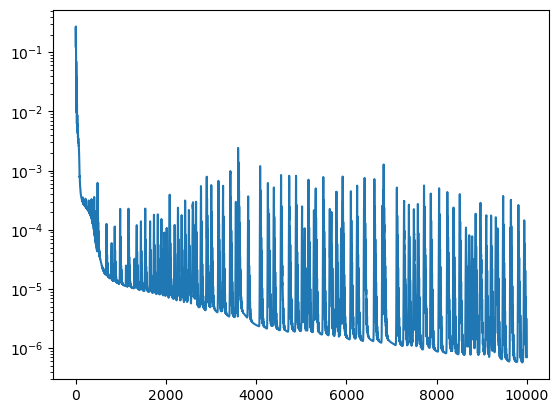

In [9]:
plt.semilogy(loss_history)

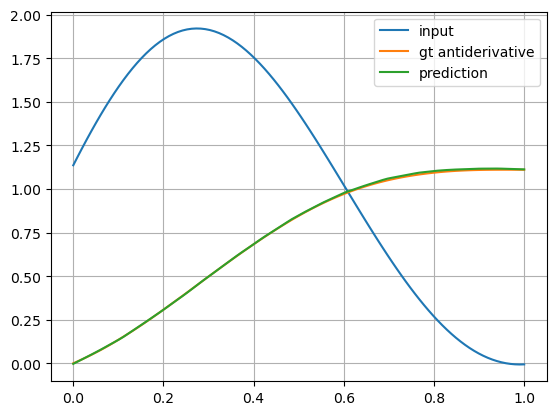

In [10]:
plt.plot(
    trunk_inputs_test[:, 0],
    branch_inputs_test[0, :],
    label="input",
)
plt.plot(
    trunk_inputs_test[:, 0],
    outputs_test[0, :],
    label="gt antiderivative",
)
plt.plot(
    trunk_inputs_test[:, 0],
    jax.vmap(
        antiderivative_operator,
        in_axes=(None, 0)
    )(branch_inputs_test[0, :], trunk_inputs_test),
    label="prediction",
)
plt.legend()
plt.grid()

In [11]:
predictions_test = jax.vmap(jax.vmap(antiderivative_operator, in_axes=(None, 0)), in_axes=(0, None,) )(branch_inputs_test, trunk_inputs_test)

def normalized_l2_error(pred, ref):
    diff_norm = jnp.linalg.norm(pred - ref)
    ref_norm = jnp.linalg.norm(ref)
    return diff_norm / ref_norm

test_errors = jax.vmap(normalized_l2_error)(predictions_test, outputs_test)
mean_test_error = jnp.mean(test_errors)
std_test_error = jnp.std(test_errors)
mean_test_error, std_test_error

2025-05-17 23:17:55.565681: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.95GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


(Array(0.00822344, dtype=float32), Array(0.01063272, dtype=float32))